# Auto Tetris
## Detecting roof surfaces from satellite images with UNET architecture

Stuff

In [1]:
# Check for Nvidia gpus
! nvidia-smi

Sun Dec  4 22:30:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   43C    P0   131W / 300W |  31935MiB / 32768MiB |     71%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:16:00.0 Off |                    0 |
| N/A   

### Data Augmentation

In [2]:
from data_augmentation import load_data, create_new_data_dirs, augment_data
from utils import del_new_data
# https://dev.to/rohitfarmer/how-to-run-jupyter-notebook-in-an-interactive-node-on-a-high-performance-computer-hpc-27mg
from pathlib import Path
import torch

In [3]:
base_path = Path.cwd().parent
base_path

PosixPath('/zhome/ac/d/174101/auto_tetris')

In [4]:
(train_x, train_y), (val_x, val_y), (test_x, test_y) = load_data(
    base_path,
    split=(70, 15, 15),
    shuffle=True,
    # max_items=200  # how many images to create dataset from, default is all images
)
print(f"{len(train_x)=} - {len(train_y)=}")
print(f"{len(val_x)=} - {len(val_y)=}")
print(f"{len(test_x)=} - {len(test_y)=}")

len(train_x)=1911 - len(train_y)=1911
len(val_x)=409 - len(val_y)=409
len(test_x)=410 - len(test_y)=410


In [5]:
# Create folders for the new data in project root
del_new_data()
create_new_data_dirs(base_path)

# data augmentation
augment_data(
    train_x,
    train_y,
    base_path / "data",
    base_path / "new_data/train",
    augment=False,
)
augment_data(
    val_x,
    val_y,
    base_path / "data",
    base_path / "new_data/val",
    augment=False
)
augment_data(
    test_x,
    test_y,
    base_path / "data",
    base_path / "new_data/test",
    augment=False,
)

Deleted new_data directory


100%|█████████████████████████████████████████| 410/410 [00:04<00:00, 86.81it/s]


### Model setup

In [85]:
! jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [86]:
from utils import seeding, create_dir, sort_path_list
from Hyperparams import Hyperparams
from data import DriveDataset
from unet import build_unet
from torch.utils.data import DataLoader
from pathlib import Path
import torch

In [87]:
seeding(42)
base_path = Path.cwd().parent
base_path

PosixPath('/zhome/ac/d/174101/auto_tetris')

In [88]:
# Load train dataset
train_x = list((base_path / "new_data/train/images/").glob("*.jpeg"))
train_y = list((base_path / "new_data/train/masks/").glob("*.jpeg"))

# Sort dataset, so images and masks match
train_x.sort(key=sort_path_list)
train_y.sort(key=sort_path_list)

# Load test dataset
val_x = list((base_path / "new_data/val/images/").glob("*.jpeg"))
val_y = list((base_path / "new_data/val/masks/").glob("*.jpeg"))

# Sort dataset, so images and masks match
val_x.sort(key=sort_path_list)
val_y.sort(key=sort_path_list)

data_str = f"Dataset size:\nTrain: {len(train_x)} - Valid: {len(val_x)}"
print(data_str)

Dataset size:
Train: 1854 - Valid: 406


In [89]:
# Directories
create_dir(base_path / "checkpoints")
checkpoint_path = base_path / "checkpoints/checkpoint.pth"

In [90]:
# Hyperparameters

hyperparams = Hyperparams(base_path / "train_conf.toml")

H = hyperparams.image_size
W = hyperparams.image_size
size = (H, W)

batch_size = hyperparams.batch_size
num_epochs = hyperparams.epochs
lr = hyperparams.lr
layers = hyperparams.layers
early_stopping_patience = 10

# Dataset and Dataloader
train_dataset = DriveDataset(train_x, train_y)
val_dataset = DriveDataset(val_x, val_y)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)

val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_unet(layers=layers)
model = model.to(device)


# optimizer = hyperparams.optimizer(model.parameters(), lr=hyperparams.lr)

optimizer = hyperparams.optimizer_class(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = hyperparams.loss_fn

### Training

In [91]:
from utils import epoch_time
import time
from train import train, evaluate
import pandas as pd
import os
from datetime import datetime
import json
from IPython.display import clear_output

In [92]:
#create DataFrame
trained_models_df = pd.DataFrame(columns=[
    'filename',
    'train_start_datetime',
    'batch_size',
    'lr',
    'layers',
    'optimizer',
    'loss',
    'trained_epochs',
    'last_saved_epoch',
    'best_val_loss',
    'early_stopping',
    'epoch_train_losses',
    'epoch_val_losses',
    'epoch_train_times',
    'total_train_time',
])

create_dir(base_path / "models")
TRAINED_MODELS_CSV = base_path / "models/trained_models.csv"

isExist = os.path.exists(TRAINED_MODELS_CSV)
if not isExist:
    trained_models_df.to_csv(TRAINED_MODELS_CSV)
    print("Created trained_models.csv")

In [93]:
train_start_datetime = datetime.now()
str(train_start_datetime)

'2022-12-05 02:05:39.243674'

In [94]:
# Training the model


train_start_datetime = datetime.now()

train_losses = []
val_losses = []
lr_epochs = []

epoch_times = []

trained_epochs = 0
last_saved_epoch = 0
early_stopping = False

best_val_loss = float("inf")

train_start = time.time()
for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    val_loss = evaluate(model, val_loader, loss_fn, device)

    """ Saving the model """
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), checkpoint_path)

    if epoch % 5 == 4:
        clear_output(wait=True)
        
    if val_loss < best_val_loss:
        data_str = f"Valid loss improved from {best_val_loss:2.4f} to {val_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
        print(data_str)
        
        best_val_loss = val_loss
        last_saved_epoch = epoch+1

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    trained_epochs = epoch+1
    data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    data_str += f'\t Val. Loss: {val_loss:.3f}\n'
    print(data_str)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    epoch_times.append(end_time - start_time)
    lr_epochs.append(lr)


    if trained_epochs - last_saved_epoch >= early_stopping_patience:
        early_stopping = True
        break


train_end = time.time()
train_mins, train_secs = epoch_time(train_start, train_end)
data_str = f'Training completed:\n'
data_str += f'\tEpochs: \t{trained_epochs}\n'
data_str += f'\tTraining Time: \t{train_mins}m {train_secs}s\n'
# data_str += f'\tTrain Loss: \t{train_loss:.3f}\n'
# data_str += f'\t Val. Loss: \t{val_loss:.3f}\n'
print(data_str)

Epoch: 40 | Epoch Time: 0m 14s
	Train Loss: 0.118
	 Val. Loss: 0.317

Training completed:
	Epochs: 	40
	Training Time: 	13m 29s



In [100]:
dict_to_append = {
    'filename': [hyperparams.model_name()],
    'train_start_datetime': [str(train_start_datetime)],
    'batch_size': [hyperparams.batch_size],
    'lr': [hyperparams.lr],
    'layers': [hyperparams.layers],
    'optimizer': [hyperparams.optimizer],
    'loss': [hyperparams.loss],
    'trained_epochs': [trained_epochs],
    'last_saved_epoch': [last_saved_epoch],
    'best_val_loss': [best_val_loss],
    'early_stopping': [early_stopping],
    'epoch_train_losses': [json.dumps(train_losses)],
    'epoch_val_losses': [json.dumps(val_losses)],
    'epoch_train_times': [json.dumps(epoch_times)],
    'total_train_time': [train_end - train_start],
}

In [96]:
new_row = pd.DataFrame.from_dict(dict_to_append)
# trained_models_df = pd.concat([trained_models_df, new_row], ignore_index=True)
new_row.to_csv(TRAINED_MODELS_CSV, mode='a', header=False)

In [97]:
model_save_path = base_path / "models" / hyperparams.model_name()

isExist = os.path.exists(model_save_path)
if not isExist:
    torch.save(model.state_dict(), model_save_path)
    print(f"Saved model to {model_save_path}")
else:
    print(f"WARNING: filename already exists, couldn't save {model_save_path}")

Saved model to /zhome/ac/d/174101/auto_tetris/models/roof_surface_model_B40_E100_lr1.000e-02_L4_SGD_Dice.pth


In [98]:
def plot_training(training_losses,
                  validation_losses,
                  gaussian=True,
                  sigma=2,
                  figsize=(8, 6)
                  ):
    """
    Returns a loss plot with training loss, validation loss
    """

    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    from scipy.ndimage import gaussian_filter

    list_len = len(training_losses)
    x_range = list(range(1, list_len + 1))  # number of x values

    fig = plt.figure(figsize=figsize)
    grid = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

    subfig1 = fig.add_subplot(grid[0])

    subfigures = fig.get_axes()

    for i, subfig in enumerate(subfigures, start=1):
        subfig.spines['top'].set_visible(False)
        subfig.spines['right'].set_visible(False)

    if gaussian:
        training_losses_gauss = gaussian_filter(training_losses, sigma=sigma)
        validation_losses_gauss = gaussian_filter(validation_losses, sigma=sigma)

        linestyle_original = '.'
        color_original_train = 'lightcoral'
        color_original_valid = 'lightgreen'
        color_smooth_train = 'red'
        color_smooth_valid = 'green'
        alpha = 0.25
    else:
        linestyle_original = '-'
        color_original_train = 'red'
        color_original_valid = 'green'
        alpha = 1.0

    # Subfig 1
    subfig1.plot(x_range, training_losses, linestyle_original, color=color_original_train, label='Training',
                 alpha=alpha)
    subfig1.plot(x_range, validation_losses, linestyle_original, color=color_original_valid, label='Validation',
                 alpha=alpha)
    if gaussian:
        subfig1.plot(x_range, training_losses_gauss, '-', color=color_smooth_train, label='Training', alpha=0.75)
        subfig1.plot(x_range, validation_losses_gauss, '-', color=color_smooth_valid, label='Validation', alpha=0.75)
    subfig1.title.set_text('Training & validation loss')
    subfig1.set_xlabel('Epoch')
    subfig1.set_ylabel('Loss')

    subfig1.legend(loc='upper right')


    return fig

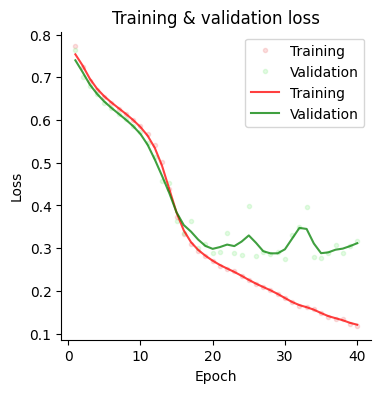

In [99]:
import matplotlib.pyplot as plt
fig = plot_training(train_losses, val_losses, gaussian=True, sigma=1, figsize=(4,4))
plt.savefig(str(hyperparams.model_name())+'.jpg')